In [1]:
import numpy as np 
import pandas as pd

from keras.applications import vgg16
from keras.layers import Input, MaxPooling2D, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout, ZeroPadding2D, UpSampling2D
from keras.models import Model, Sequential, load_model
from keras import backend as K
from keras import optimizers
from keras import utils
from keras.initializers import RandomNormal
from keras.preprocessing.image import ImageDataGenerator

import cv2
import os
from PIL import Image
import json
import os
import time
from tqdm import tqdm
import matplotlib.pyplot as plt


os.listdir()

['.config',
 '.ipynb_checkpoints',
 '2nd_model',
 'train_y.csv',
 'train_x.npy',
 'train_x_pre.npy',
 'test_x.npy',
 'first_model',
 'results.zip',
 '2nd_model.zip',
 'test_x_pre.npy',
 'first_model.zip',
 'sample_data']

In [ ]:
!unzip test_x.npy.zip
!unzip train_x.npy.zip

Archive:  test_x.npy.zip
replace test_x.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
Archive:  train_x.npy.zip
replace train_x.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [2]:
# Load Dataset
train_x = np.load("train_x_pre.npy")
test_x = np.load("test_x_pre.npy")
train_y = pd.read_csv("train_y.csv")
train_y = train_y.Label.to_numpy()

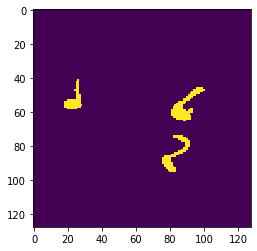

Image shape: (128, 128, 1)
Label: 6
X train size: (40000, 128, 128, 1)
Y train size: 40000


In [3]:
def show_image(arr):
    two_d = (np.reshape(arr, (128, 128)) * 255).astype(np.uint8)
    plt.imshow(two_d, interpolation='nearest')
    plt.show()

show_image(train_x[0])
print(f'Image shape: {train_x[0].shape}')
print(f'Label: {train_y[0]}')
print(f'X train size: {train_x.shape}')
print(f'Y train size: {len(train_y)}')

In [12]:
test_x = np.load("test_x_pre.npy")

In [4]:
num_classes = 10
input_shape = (128,128,1)
batch_size = 30
epochs = 30

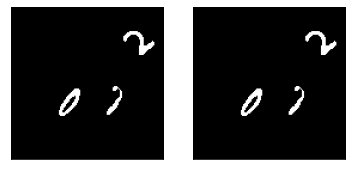

In [4]:
#@title img processing test
threshold = 220
i = 2
test = train_x[i]
denoised = cv2.fastNlMeansDenoising(np.uint8(test),90,25,7,21)
ret,thresh = cv2.threshold(denoised,threshold,255,cv2.THRESH_BINARY)

plt.subplot(1,2,1)
plt.imshow(test,'gray')
plt.xticks([]),plt.yticks([])
plt.subplot(1,2,2)
plt.imshow(thresh, 'gray')
plt.xticks([]),plt.yticks([])

plt.show()

In [ ]:
def preprocess(img):
  threshold = 220
  denoised = cv2.fastNlMeansDenoising(np.uint8(img),90,25,7,21)
  ret,thresh = cv2.threshold(denoised,threshold,255,cv2.THRESH_BINARY)
  return thresh

In [ ]:
#only run when loaded with fresh data
train_x = [preprocess(img) for img in tqdm(train_x)]
test_x = [preprocess(img) for img in tqdm(test_x)]

x_train = train_x/ 255
x_test = test_x / 255
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

np.save('train_x_pre.npy', x_train)
np.save('test_x_pre.npy', x_test)

In [ ]:
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

In [5]:
y_train = utils.to_categorical(train_y, num_classes)

In [6]:
train_datagen = ImageDataGenerator(zoom_range=0.3, rotation_range=30,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, fill_mode='nearest',
                                   validation_split=0.1)

In [7]:
train_generator = train_datagen.flow(train_x, y_train, batch_size=batch_size, subset='training')
validation_generator = train_datagen.flow(train_x, y_train, batch_size=batch_size, subset='validation')

In [ ]:
#Attempt at transfer learning using vgg16
vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                                     input_shape=input_shape)
output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)

vgg_model.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False

In [8]:
#if wanna resume from last session
model = load_model('2nd_model')

In [8]:
model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='CategoricalCrossentropy',
          optimizer=optimizers.Adam(learning_rate=0.0001),
          metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 16)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        9280      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 128)       1

In [ ]:
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs=epochs,
                    verbose=1)

Epoch 1/30
1200/1200 [==============================] - 56s 47ms/step - loss: 0.6130 - accuracy: 0.7933 - val_loss: 0.5946 - val_accuracy: 0.7980
Epoch 2/30
1200/1200 [==============================] - 56s 47ms/step - loss: 0.6088 - accuracy: 0.7947 - val_loss: 0.6228 - val_accuracy: 0.7922
Epoch 3/30
1200/1200 [==============================] - 56s 46ms/step - loss: 0.6062 - accuracy: 0.7943 - val_loss: 0.6056 - val_accuracy: 0.7965
Epoch 4/30
1200/1200 [==============================] - 56s 46ms/step - loss: 0.5964 - accuracy: 0.7989 - val_loss: 0.6211 - val_accuracy: 0.7908
Epoch 5/30
1200/1200 [==============================] - 55s 46ms/step - loss: 0.5999 - accuracy: 0.7969 - val_loss: 0.6154 - val_accuracy: 0.7922
Epoch 6/30
1200/1200 [==============================] - 56s 46ms/step - loss: 0.5924 - accuracy: 0.8004 - val_loss: 0.6092 - val_accuracy: 0.7977
Epoch 7/30
1200/1200 [==============================] - 56s 47ms/step - loss: 0.5985 - accuracy: 0.7977 - val_loss: 0.5877 -

In [12]:
model.save('2nd_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: 2nd_model/assets


In [13]:
!zip -r 2nd_model.zip 2nd_model

  adding: 2nd_model/ (stored 0%)
  adding: 2nd_model/variables/ (stored 0%)
  adding: 2nd_model/variables/variables.index (deflated 68%)
  adding: 2nd_model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: 2nd_model/assets/ (stored 0%)
  adding: 2nd_model/saved_model.pb (deflated 89%)


In [3]:
rec_model = load_model('2nd_model')

In [13]:
test_x.shape

(10000, 128, 128, 1)

In [14]:
type(test_x[0])

numpy.ndarray

In [15]:
results = rec_model.predict(test_x)

In [16]:
results = [np.argmax(x) for x in results]

In [17]:
results = np.array(results)
results = results.flatten()
results.shape

(10000,)

In [18]:
dict_results = {'Id': np.arange(len(results)), 'Label': results}
df_results = pd.DataFrame(data=dict_results)

In [19]:
df_results

,Id,Label
0,0,7
1,1,5
2,2,9
3,3,8
4,4,6
...,...,...
9995,9995,5
9996,9996,9
9997,9997,5
9998,9998,3


In [20]:
compression_opts = dict(method='zip',
                        archive_name='results.csv')  
df_results.to_csv('results.zip', index=False, compression=compression_opts)